In [208]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMRegressor
# class sklearn.model_selection.StratifiedKFold(n_splits=5,
#     shuffle=False, random_state=None)
from typing import Union, Tuple
import warnings
import numpy as np
import scipy.stats as stats
warnings.simplefilter('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [209]:
df = pd.read_csv('/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/data_for_revise/prediction/brand_classification/データセット完成目的変数全て入っている.csv')
df

,県,エリア,サロン名,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,コメントへの返信率,駅徒歩,イルミナメニュー化の有無,Aujuaメニュー化の有無,addicthyメニュー化の有無,inoaメニュー化の有無
0,島根,松江,Rote【ロテ】,18,237,179,7,24,41,48,0.983,5.0,0,0,0,0
1,島根,松江,freedom belinda 松江学園店 【フリーダム ベリンダ】,10,15,161,8,34,42,5,0.130,NaN,0,0,1,0
2,島根,松江,SMITH AVEDA,10,97,209,5,15,24,23,0.981,NaN,0,0,0,0
3,島根,松江,freedom rita【フリーダム リタ】,4,0,63,3,29,37,0,0.000,NaN,0,0,0,0
4,島根,松江,lamiell matsue 【ラミールマツエ】,8,104,340,8,30,26,44,0.767,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,Chill hair,1,0,50,1,0,16,0,0.000,NaN,0,0,0,0
4075,福山・尾道,福山駅前・三吉周辺,SOYU headspa by Palm 【ソユ】,2,0,33,2,0,23,0,0.970,NaN,0,0,0,0
4076,福山・尾道,福山駅前・三吉周辺,Triangle,4,0,3,1,0,43,0,1.000,NaN,0,0,0,0
4077,福山・尾道,福山駅前・三吉周辺,Calin【カラン】,1,0,43,1,0,12,0,0.721,NaN,0,0,0,0


In [184]:
df['inoaメニュー化の有無'].value_counts()

0    4016
1      63
Name: inoaメニュー化の有無, dtype: int64

In [13]:
# 連続値の層化抽出クラスの定義
class ContinuousStratifiedKFold:
    def __init__(self, n_split: int=5, shuffle: bool=True, random_state: int=42) -> None:
        self.n_split = n_split
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X: pd.DataFrame, reference: pd.Series, bins: int=10,
                      suffle: Union[bool]=None, random_state: Union[int]=None) -> Tuple[np.ndarray, np.ndarray]:

        shuffle = shuffle if suffle is not None else self.shuffle
        random_state = random_state if random_state is not None else self.random_state
        min_ref, max_ref = int(reference.min() - 1), int(reference.max() + 1)
        cut_threshold = np.linspace(min_ref, max_ref, bins)
        out = pd.cut(reference, bins=cut_threshold, labels=False)

        skf = StratifiedKFold(self.n_split, shuffle=shuffle, random_state=random_state)
        for train_idx, val_idx in skf.split(X, out):
            yield train_idx, val_idx

# イルミナメニュー化の有無モデル作成

In [14]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [15]:
prediction_column = 'イルミナメニュー化の有無'

In [16]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,イルミナメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [17]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [18]:
params={
    "n_estimators": 10000,
    "learning_rate":0.1,
    "random_seed":0,
    "num_leaves":50,
    "max_depth":60,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'binary',
}

In [34]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, f1_score, recall_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
models = []
f1_scores = []
precision_scores = []
recall_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMClassifier(**params)

    
    model.fit(X_train, y_train, 
         eval_metric='binary_logloss',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    
    y_pred = model.predict(X_valid)
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    recall= recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_pred,y_valid)

    models.append(model)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    

1it [00:00,  4.56it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.332548


2it [00:00,  5.77it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.330085
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.334095


5it [00:00,  8.74it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.345719
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.348399


In [35]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["f1_score", "presiodion", "recall"]])

df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores
df_result["recall"] = recall_scores


# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,f1_score,presiodion,recall
0,0.217054,0.636364,0.130841
1,0.240000,0.833333,0.140187
2,0.238806,0.592593,0.149533
3,0.162602,0.625000,0.093458
4,0.120690,0.700000,0.066038


0.0 1.0 1.0


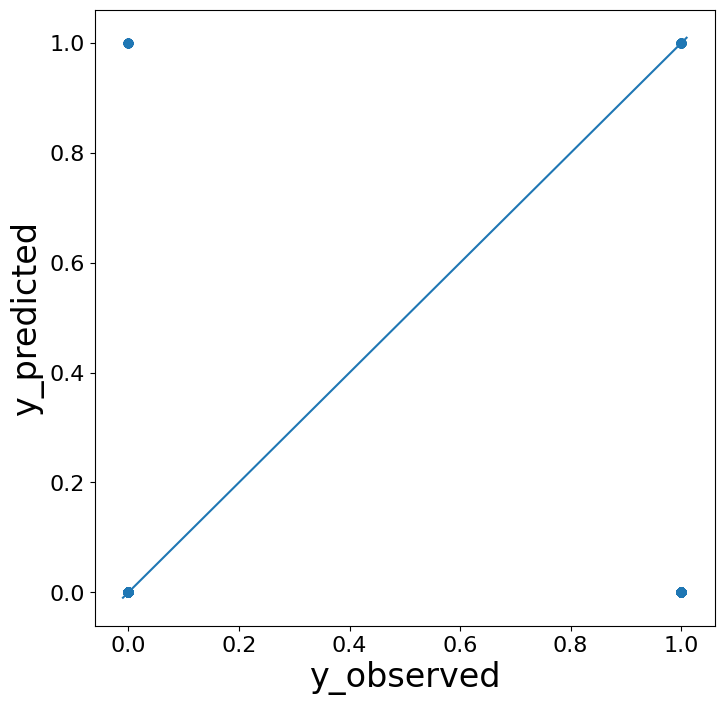

決定係数：-0.084
RMSE：0.35


In [37]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = ""

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [45]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

2374    0
Name: イルミナメニュー化の有無, dtype: int64

In [46]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([0]), array([0]), array([0]), array([0]), array([0])]
0


In [47]:
print((_score_mode), float(tmp_df_y))

0 0.0


In [48]:
_scores=[]
for model in models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([0.08809655]), array([0.19281339]), array([0.10538755]), array([0.07944203]), array([0.07201154])]


In [49]:
print(round(_score,2), float(tmp_df_y))

0.19 0.0


In [51]:
import pickle

with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/brand_classification/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 'Aujuaメニュー化の有無'モデル作成

In [52]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [53]:
prediction_column = 'Aujuaメニュー化の有無'

In [54]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,Aujuaメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [55]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [56]:
params={
    "n_estimators": 10000,
    "learning_rate":0.1,
    "random_seed":0,
    "num_leaves":100,
    "max_depth":60,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'binary',
}

In [57]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, f1_score, recall_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
models = []
f1_scores = []
precision_scores = []
recall_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMClassifier(**params)

    
    model.fit(X_train, y_train, 
         eval_metric='binary_logloss',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    
    y_pred = model.predict(X_valid)
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    recall= recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_pred,y_valid)

    models.append(model)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    

0it [00:00, ?it/s]

Training until validation scores don't improve for 10 rounds


3it [00:00,  9.45it/s]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.196162
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.193234
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.199906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.178461


5it [00:00, 10.01it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.174654


In [58]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["f1_score", "presiodion", "recall"]])

df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores
df_result["recall"] = recall_scores


# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,f1_score,presiodion,recall
0,0.113208,0.600000,0.062500
1,0.076923,0.500000,0.041667
2,0.145455,0.666667,0.081633
3,0.111111,0.600000,0.061224
4,0.150943,0.800000,0.083333


0.0 1.0 1.0


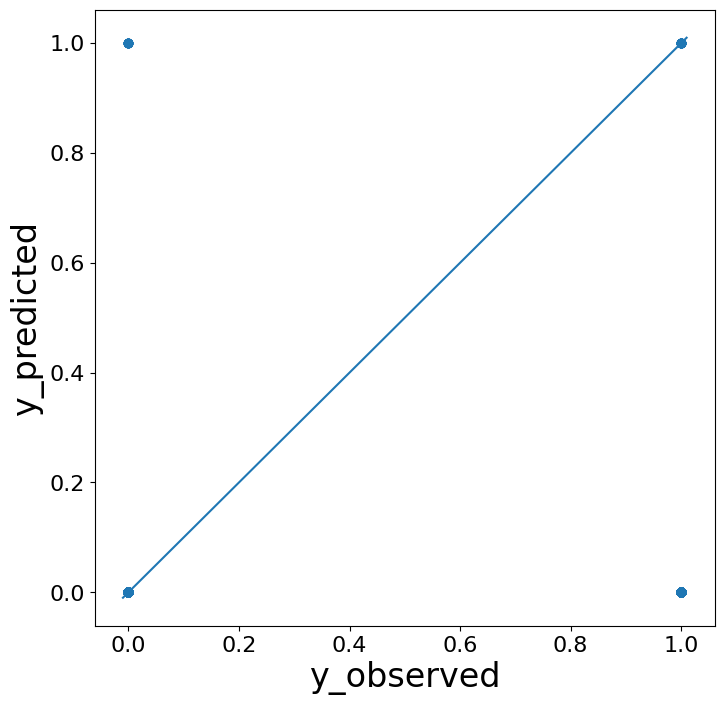

決定係数：-0.032
RMSE：0.24


In [59]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = ""

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [116]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

1962    1
Name: Aujuaメニュー化の有無, dtype: int64

In [117]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([0]), array([0]), array([0]), array([1]), array([0])]
0


In [118]:
print((_score_mode), float(tmp_df_y))

0 1.0


In [119]:
_scores=[]
for model in models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([0.47650709]), array([0.07712854]), array([0.32662504]), array([0.59634559]), array([0.45078651])]


In [120]:
print(round(_score,2), float(tmp_df_y))

0.6 1.0


In [121]:
import pickle

with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/brand_classification/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 'addicthyメニュー化の有無'モデル作成

In [122]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [123]:
prediction_column = 'addicthyメニュー化の有無'

In [124]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,addicthyメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,1
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [125]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [126]:
params={
    "n_estimators": 10000,
    "learning_rate":0.1,
    "random_seed":0,
    "num_leaves":100,
    "max_depth":60,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'binary',
}

In [127]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, f1_score, recall_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
models = []
f1_scores = []
precision_scores = []
recall_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMClassifier(**params)

    
    model.fit(X_train, y_train, 
         eval_metric='binary_logloss',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    
    y_pred = model.predict(X_valid)
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    recall= recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_pred,y_valid)

    models.append(model)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    

0it [00:00, ?it/s]

Training until validation scores don't improve for 10 rounds


1it [00:00,  3.00it/s]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.196165
Training until validation scores don't improve for 10 rounds


5it [00:00,  7.05it/s]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.194508
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.199564
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.208926
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.197402


In [128]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["f1_score", "presiodion", "recall"]])

df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores
df_result["recall"] = recall_scores


# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,f1_score,presiodion,recall
0,0.231884,0.666667,0.140351
1,0.324324,0.750000,0.206897
2,0.373333,0.823529,0.241379
3,0.281690,0.769231,0.172414
4,0.394737,0.789474,0.263158


0.0 1.0 1.0


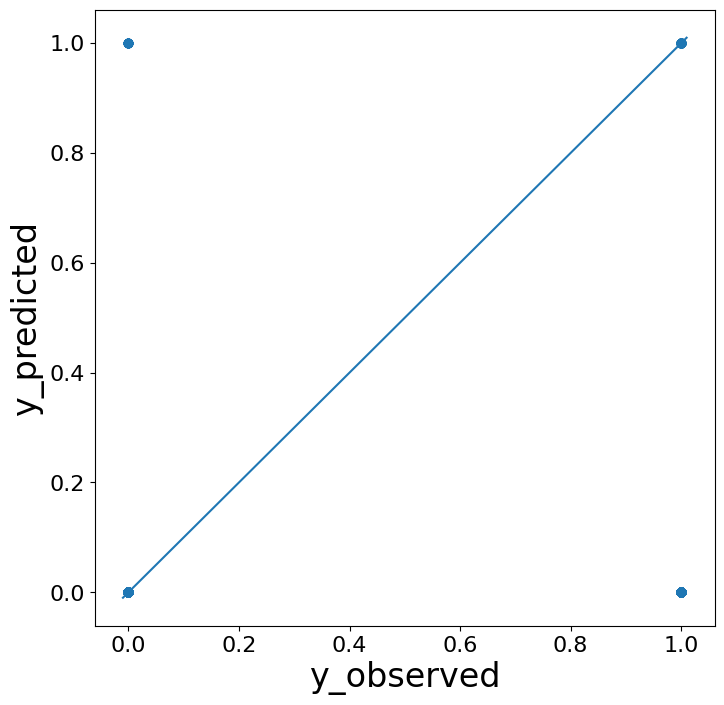

決定係数：0.077
RMSE：0.25


In [129]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = ""

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [140]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

1197    0
Name: addicthyメニュー化の有無, dtype: int64

In [141]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([0]), array([0]), array([0]), array([0]), array([0])]
0


In [142]:
print((_score_mode), float(tmp_df_y))

0 0.0


In [143]:
_scores=[]
for model in models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([0.0736745]), array([0.03617589]), array([0.05181083]), array([0.04332941]), array([0.06103336])]


In [144]:
print(round(_score,2), float(tmp_df_y))

0.07 0.0


In [145]:
import pickle

with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/brand_classification/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)

# 'inoaメニュー化の有無'モデル作成

In [204]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [211]:
prediction_column = 'inoaメニュー化の有無'

In [212]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,inoaメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [215]:
_df['inoaメニュー化の有無'].value_counts()

0    4016
1     126
Name: inoaメニュー化の有無, dtype: int64

In [214]:
_df = pd.concat([_df, _df[_df['inoaメニュー化の有無']==1]])
_df=_df.reset_index(drop=True)

In [216]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [217]:
params={
    "n_estimators": 10000,
    "learning_rate":0.1,
    "random_seed":0,
    "num_leaves":100,
    "max_depth":60,
    "n_jobs": -1,
    "categorical_feature":['県', 'エリア'],
    'objective': 'binary',
}

In [218]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, f1_score, recall_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
models = []
f1_scores = []
precision_scores = []
recall_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    model = LGBMClassifier(**params)

    
    model.fit(X_train, y_train, 
         eval_metric='binary_logloss',  # early_stoppingの評価指標(学習用の'metric'パラメータにも同じ指標が自動入力される)
         eval_set=[(X_valid, y_valid)],
         callbacks=[lgb.early_stopping(stopping_rounds=10)]
         )
    
    y_pred = model.predict(X_valid)
    
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    recall= recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_pred,y_valid)

    models.append(model)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    

1it [00:00,  8.23it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.0648224
Training until validation scores don't improve for 10 rounds


3it [00:00,  8.08it/s]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0240525
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0336984
Training until validation scores don't improve for 10 rounds


5it [00:00,  7.75it/s]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.034574
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.0261503


In [219]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["f1_score", "presiodion", "recall"]])

df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores
df_result["recall"] = recall_scores


# 結果をcsvファイルに書き出す
# df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,f1_score,presiodion,recall
0,0.809524,1.000000,0.680000
1,0.916667,1.000000,0.846154
2,0.913043,1.000000,0.840000
3,0.863636,1.000000,0.760000
4,0.938776,0.958333,0.920000


0.0 1.0 1.0


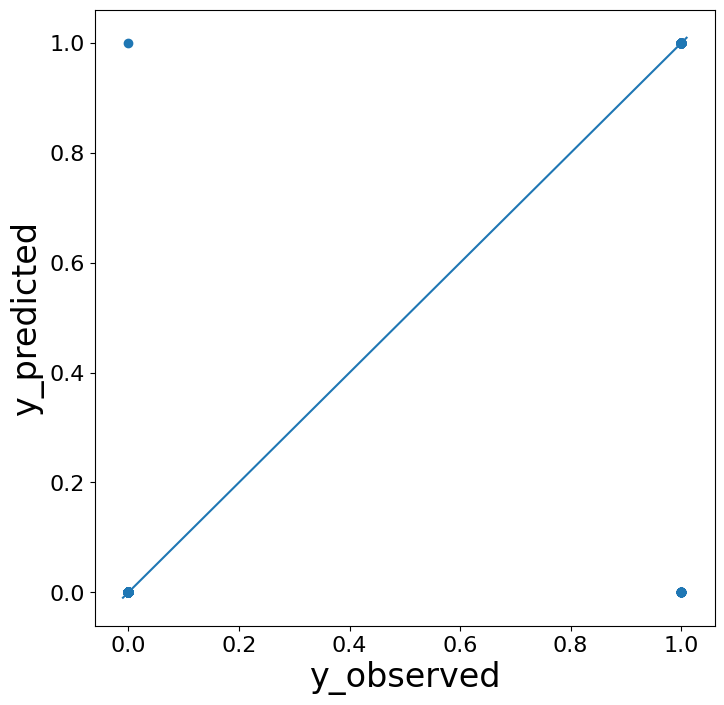

決定係数：0.795
RMSE：0.08


In [225]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = ""

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [285]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

1677    1
Name: inoaメニュー化の有無, dtype: int64

In [286]:
_scores=[]
for model in models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([1]), array([1]), array([1]), array([1]), array([1])]
1


In [287]:
print((_score_mode), float(tmp_df_y))

1 1.0


In [288]:
_scores=[]
for model in models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([0.74340289]), array([0.9808985]), array([0.87522297]), array([0.96112162]), array([0.96909235])]


In [289]:
print(round(_score,2), float(tmp_df_y))

0.91 1.0


In [290]:
import pickle

with open(f'/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/model/brand_classification/{prediction_column}_models.pkl', mode='wb') as p:
    pickle.dump(models, p)